In [39]:
total_files  = 30
Source       = "/lakehouse/default/Files/0_Source/ARCHIVE/Daily_Reports/"
Destination  = "/lakehouse/default/Files/1_Transform/0/ARCHIVE/Daily_Reports/"

In [40]:
!pip install    -q duckdb
!pip install    -q getdaft
!pip install    -q polars --upgrade
!pip install    -q chdb
!pip install    -q "ibis-framework[duckdb]"
!pip install    -q sqlframe
!pip install    -q pandas
!pip install    -q deltalake==0.18.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlframe 3.2.0 requires sqlglot<25.19,>=24.0.0, but you have sqlglot 20.11.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires sqlglot<=20.11,>=20.8.0, but you have sqlglot 25.18.0 which is incompatible.
ibis-framework 8.0.0 requires sqlglot<=20.11,>=18.12.0, but you have sqlglot 25.18.0 which is incompatible.


***Import***

In [41]:
import pandas as pd
import re
import shutil
from   urllib.request import urlopen
import os
import requests
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow         as pa
from   pyarrow         import csv
import pyarrow.compute as pc
import multiprocessing
from   shutil import unpack_archive
import time
from   datetime import datetime
from   deltalake.writer import write_deltalake
import glob
import duckdb
from psutil import *
import ibis
import ibis.expr.datatypes as dt
import daft
from   daft import DataType, col
from   sqlframe.duckdb.session import DuckDBSession
from   sqlframe.duckdb import functions as F
import polars as pl
from chdb import session as chs

<mark><u>_**For writing to Blobfuse (Mounted onelake, Databricks Volume etc, you need to pass those options**_</u></mark>

In [42]:
storage_options={"allow_unsafe_rename":"true"}
os.environ['MOUNT_ALLOW_UNSAFE_RENAME'] = "true"

In [43]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:13.0


# Download Data

In [44]:
# @title
def download(url,Path,x):
    #run only once to create an empty log file
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
      os.makedirs(Path+"_log", exist_ok=True)
      log_tb = pa.Table.from_pylist( ['x'], schema=pa.schema({ "file" : pa.string()}))
      pq.write_table(log_tb,Path+"_log/log.parquet")
    # Regex don't ask I just copy it
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = dict.fromkeys(filelist1)
    filelist_sorted=sorted(filelist_unique, reverse=True)
    filelist = filelist_sorted[:x]
    ### Read from existing log
    try:
      df = ds.dataset(Path + "_log/log.parquet").to_table().to_pandas()
      file_loaded= df['file'].unique().tolist()
    except:
      os.makedirs(Path+"_log", exist_ok=True)
      file_loaded=[os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    current = file_loaded
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))
    print(str(len(files_to_upload)) + ' New File Loaded')
    if len(files_to_upload) != 0 :
      for x in files_to_upload:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)

    #print(log)
    L=[os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    log = pd.DataFrame({'file':L})
    log_tb=pa.Table.from_pandas(log,preserve_index=False)
    #print(log_tb)
    log_schema = pa.schema([pa.field('file', pa.string())])
    log_tb=log_tb.cast(target_schema=log_schema)
    pq.write_table(log_tb,Path+"_log/log.parquet")
    return "done"

In [45]:
# @title
def uncompress(x):
        unpack_archive(str(Source+x), str(Destination), 'zip')
def unzip(Source, Destination,Nbr_Files_to_Download):

    #run only once to create an empty log file
    if not os.path.exists(Destination):
      os.makedirs(Destination, exist_ok=True)
      os.makedirs(Destination+"_log", exist_ok=True)
      log_tb = pa.Table.from_pylist( ['x'], schema=pa.schema({ "file" : pa.string()}))
      pq.write_table(log_tb,Destination+"_log/log.parquet")
    # check zip files
    try:
     df = ds.dataset(Source + "_log/log.parquet").to_table().to_pandas()
     filelist_unique= df['file'].unique()
     filelist=filelist_unique.tolist()
    except:
     filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    filelist =sorted(filelist, reverse=True)
    ### checl the unzipped files already
    df = ds.dataset(Destination + "_log/log.parquet").to_table().to_pandas()
    file_loaded= df['file'].unique()
    current = file_loaded.tolist()
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))[:Nbr_Files_to_Download]
    #unzip only the delta
    print(str(len(files_to_upload)) + ' New File uncompressed')
    if len(files_to_upload) != 0 :
      with multiprocessing.Pool() as pool:
       for _ in pool.imap_unordered(uncompress, files_to_upload, chunksize=1):
         pass
      existing_file = pd.DataFrame( file_loaded)
      new_file = pd.DataFrame(  files_to_upload)
      log = pd.concat ([new_file,existing_file], ignore_index=True)
      #print(log)
      log.rename(columns={0: 'file'}, inplace=True)
      log_tb=pa.Table.from_pandas(log,preserve_index=False)
      #print(log_tb)
      log_schema = pa.schema([pa.field('file', pa.string())])
      log_tb=log_tb.cast(target_schema=log_schema)
      pq.write_table(log_tb,Destination+"_log/log.parquet")
      return "done"
    else:
     return "nothing to see here"

In [46]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",Source,total_files)
unzip(Source,Destination,total_files)

20 New File Loaded
20 New File uncompressed


'done'

# DuckDB

In [47]:
# @title
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)

	df=duckdb.sql(""" select UNIT, DUID,filename,cast(columns(*exclude(DUID,UNIT,SETTLEMENTDATE,I,XX,filename)) as double),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as year  from raw  """).record_batch()

	write_deltalake(f"/lakehouse/default/Tables/T{total_files}/duckdb",df, mode="append", partition_by=['year'], storage_options= storage_options)
	return "done"


# Daft

In [48]:
# @title
def daft_clean_csv(files_to_upload_full_Path):
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True)
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", df["SETTLEMENTDATE"].str.to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('year', col('SETTLEMENTDATE').dt.year())
	df.write_deltalake(f"/lakehouse/default/Tables/T{total_files}/daft", mode="append")
	return "done"

# Polars

In [49]:
# @title
def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x, skip_rows=1, schema=schema, has_header=False,truncate_ragged_lines=True)
  transform =(
      raw
      .filter( (pl.col("I")=='D') &  (pl.col("UNIT")=='DUNIT') & (pl.col("VERSION")=='3') )
      .drop("XX","I")
  )

  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE','DUID','UNIT','xxx'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),year=pl.col("SETTLEMENTDATE").dt.iso_year()).collect(streaming=True)
  final.write_delta(f"/lakehouse/default/Tables/T{total_files}/polars",mode="append",  storage_options= storage_options)
  return "done"

# Pyarrow

In [50]:
# @title
def pyarrow_clean_csv(files_to_upload_full_Path):
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format).filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= raw.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"year", pc.year(df['SETTLEMENTDATE']))
  write_deltalake(f"/lakehouse/default/Tables/T{total_files}/pyarrow",df, mode="append", partition_by=['year'], storage_options= storage_options)
  return "done"

# Pandas

In [51]:
# @title
def pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['year'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    xx= pa.Table.from_pandas(appended_data,preserve_index=False)
    write_deltalake(f"/lakehouse/default/Tables/T{total_files}/pandas",xx, mode="append", partition_by=['year'],storage_options= storage_options)
    return "done"

# chDB

In [52]:
# @title
def chdb_clean_csv(files_to_upload_full_Path):
    L = tuple(files_to_upload_full_Path)
    sql =f"""
      with raw as ( SELECT   *, _file,_path  FROM file('/lakehouse/default/Files/1_Transform/0/ARCHIVE/Daily_Reports/*.CSV','CSV')
           WHERE c1 = 'D' AND c2 = 'DUNIT' AND c4 = '3' )
      select
      c2 as UNIT,
      toFloat64OrNull(c4) AS VERSION,
      parseDateTimeBestEffort( c5) AS SETTLEMENTDATE ,
      toFloat64OrNull(c6) AS RUNNO,
      c7  AS DUID,
      toFloat64OrNull(c8) AS INTERVENTION,
      toFloat64OrNull(c9) AS DISPATCHMODE,
      toFloat64OrNull(c10) AS AGCSTATUS,
      toFloat64OrNull(c11) AS INITIALMW,
      toFloat64OrNull(c12) AS TOTALCLEARED,
      toFloat64OrNull(c13) AS RAMPDOWNRATE,
      toFloat64OrNull(c14) AS RAMPUPRATE,
      toFloat64OrNull(c15) AS LOWER5MIN,
      toFloat64OrNull(c16) AS LOWER60SEC,
      toFloat64OrNull(c17) AS LOWER6SEC,
      toFloat64OrNull(c18) AS RAISE5MIN,
      toFloat64OrNull(c19) AS RAISE60SEC,
      toFloat64OrNull(c20) AS RAISE6SEC,
      toFloat64OrNull(c21) AS MARGINAL5MINVALUE,
      toFloat64OrNull(c22) AS MARGINAL60SECVALUE,
      toFloat64OrNull(c23) AS MARGINAL6SECVALUE,
      toFloat64OrNull(c24) AS MARGINALVALUE,
      toFloat64OrNull(c25) AS VIOLATION5MINDEGREE,
      toFloat64OrNull(c26) AS VIOLATION60SECDEGREE,
      toFloat64OrNull(c27) AS VIOLATION6SECDEGREE,
      toFloat64OrNull(c28) AS VIOLATIONDEGREE,
      toFloat64OrNull(c29) AS LOWERREG,
      toFloat64OrNull(c30) AS RAISEREG,
      toFloat64OrNull(c31) AS AVAILABILITY,
      toFloat64OrNull(c32) AS RAISE6SECFLAGS,
      toFloat64OrNull(c33) AS RAISE60SECFLAGS,
      toFloat64OrNull(c34) AS RAISE5MINFLAGS,
      toFloat64OrNull(c35) AS RAISEREGFLAGS,
      toFloat64OrNull(c36) AS LOWER6SECFLAGS,
      toFloat64OrNull(c37) AS LOWER60SECFLAGS,
      toFloat64OrNull(c38) AS LOWER5MINFLAGS,
      toFloat64OrNull(c39) AS LOWERREGFLAGS,
      toFloat64OrNull(c40) AS RAISEREGAVAILABILITY,
      toFloat64OrNull(c41) AS RAISEREGENABLEMENTMAX,
      toFloat64OrNull(c42) AS RAISEREGENABLEMENTMIN,
      toFloat64OrNull(c43) AS LOWERREGAVAILABILITY,
      toFloat64OrNull(c44) AS LOWERREGENABLEMENTMAX,
      toFloat64OrNull(c45) AS LOWERREGENABLEMENTMIN,
      toFloat64OrNull(c46) AS RAISE6SECACTUALAVAILABILITY,
      toFloat64OrNull(c47) AS RAISE60SECACTUALAVAILABILITY,
      toFloat64OrNull(c48) AS RAISE5MINACTUALAVAILABILITY,
      toFloat64OrNull(c49) AS RAISEREGACTUALAVAILABILITY,
      toFloat64OrNull(c50) AS LOWER6SECACTUALAVAILABILITY,
      toFloat64OrNull(c51) AS LOWER60SECACTUALAVAILABILITY,
      toFloat64OrNull(c52) AS LOWER5MINACTUALAVAILABILITY,
      toFloat64OrNull(c53) AS LOWERREGACTUALAVAILABILITY,
      _file as filename,
      toYear(CAST(SETTLEMENTDATE AS DateTime)) AS year
      from raw   where _path IN {L}
   """
    sess = chs.Session()
    sess.query('''
    SET input_format_csv_use_best_effort_in_schema_inference = 0;
    SET input_format_csv_skip_first_lines = 1;
    SET input_format_csv_allow_variable_number_of_columns = 1 ;''')
    sess.query(sql)
    df = sess.sql(sql,"dataframe")
    write_deltalake(f"/lakehouse/default/Tables/T{total_files}/chdb",df, mode="append", partition_by=['year'], storage_options= storage_options)
    return "done"


# Ibis

In [53]:
# @title
def ibis_clean_csv(files_to_upload_full_Path):
 schema={
			'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
			'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
			'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
			'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
			'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
			'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
			'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
			'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
			'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
			'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
			'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
			'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
			'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
			'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
			'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
			'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
		}
 raw = ibis.read_csv(files_to_upload_full_Path,Skip=1,header =0,all_varchar=1,columns =schema,filename =1,null_padding = 1,ignore_errors=1,auto_detect=0)
 DUNIT = raw.filter((raw.UNIT == "DUNIT") & (raw.VERSION  == '3') & (raw.I  == 'D')).drop("XX","I")
 DUNIT = DUNIT.cast({"SETTLEMENTDATE": dt.Timestamp(timezone="UTC")})
 DUNIT = DUNIT.mutate(date=DUNIT.SETTLEMENTDATE.cast("date"), year=DUNIT.SETTLEMENTDATE.year(),)
 df_cols = list(set(DUNIT.columns) - {'SETTLEMENTDATE','DUID','filename','UNIT','date','year'})
 DUNIT = DUNIT.cast({col_name: "double" for col_name in df_cols})
 DUNIT.to_delta(f"/lakehouse/default/Tables/T{total_files}/ibis",mode="append", partition_by=['year'], storage_options= storage_options)
 return "done"

# Sqlframe

In [54]:
# @title
def sqlframe_clean_csv(files_to_upload_full_Path):
  session = DuckDBSession()
  df = session.read.load(
      files_to_upload_full_Path,
      schema="""I VARCHAR, UNIT VARCHAR, XX VARCHAR, VERSION VARCHAR, SETTLEMENTDATE VARCHAR, RUNNO VARCHAR, DUID VARCHAR,
      INTERVENTION VARCHAR, DISPATCHMODE VARCHAR, AGCSTATUS VARCHAR, INITIALMW VARCHAR, TOTALCLEARED VARCHAR, RAMPDOWNRATE VARCHAR,
      RAMPUPRATE VARCHAR, LOWER5MIN VARCHAR, LOWER60SEC VARCHAR, LOWER6SEC VARCHAR, RAISE5MIN VARCHAR, RAISE60SEC VARCHAR, RAISE6SEC VARCHAR,
      MARGINAL5MINVALUE VARCHAR, MARGINAL60SECVALUE VARCHAR, MARGINAL6SECVALUE VARCHAR, MARGINALVALUE VARCHAR, VIOLATION5MINDEGREE VARCHAR,
      VIOLATION60SECDEGREE VARCHAR, VIOLATION6SECDEGREE VARCHAR, VIOLATIONDEGREE VARCHAR, LOWERREG VARCHAR, RAISEREG VARCHAR, AVAILABILITY VARCHAR,
      RAISE6SECFLAGS VARCHAR, RAISE60SECFLAGS VARCHAR, RAISE5MINFLAGS VARCHAR, RAISEREGFLAGS VARCHAR, LOWER6SECFLAGS VARCHAR, LOWER60SECFLAGS VARCHAR,
      LOWER5MINFLAGS VARCHAR, LOWERREGFLAGS VARCHAR, RAISEREGAVAILABILITY VARCHAR, RAISEREGENABLEMENTMAX VARCHAR, RAISEREGENABLEMENTMIN VARCHAR,
      LOWERREGAVAILABILITY VARCHAR, LOWERREGENABLEMENTMAX VARCHAR, LOWERREGENABLEMENTMIN VARCHAR, RAISE6SECACTUALAVAILABILITY VARCHAR,
      RAISE60SECACTUALAVAILABILITY VARCHAR, RAISE5MINACTUALAVAILABILITY VARCHAR, RAISEREGACTUALAVAILABILITY VARCHAR,
      LOWER6SECACTUALAVAILABILITY VARCHAR, LOWER60SECACTUALAVAILABILITY VARCHAR, LOWER5MINACTUALAVAILABILITY VARCHAR,
      LOWERREGACTUALAVAILABILITY VARCHAR""",
      format="csv", skip=1, header=1, all_varchar=1, filename=1, null_padding=True, ignore_errors=1, auto_detect=False)\
      .filter("unit='DUNIT' and version =3 and i='D'")\
      .drop('xx','I')\
      .withColumn('SETTLEMENTDATE',F.to_timestamp('SETTLEMENTDATE',"yyyy/MM/dd HH:mm:ss"))\
      .withColumn("PRIORITY", F.lit(1))
  exclude_list = ['settlementdate','duid','filename','unit','priority']
  df = df.withColumns({i:F.col(i).cast("double") for i in df.columns if i not in exclude_list})
  df = df.withColumn('DATE', F.to_date(F.col('SETTLEMENTDATE')))\
        .withColumn('YEAR', F.year(F.col('SETTLEMENTDATE')))
  write_deltalake(f"/lakehouse/default/Tables/T{total_files}/sqlframe",df.toArrow(batch_size=1000*2048),
                     mode="append", partition_by=['year'], storage_options= storage_options)
  return "done"

In [55]:
# @title
# work in Progress
def xxx():
    !pip install 'ibis-framework[datafusion]'
    con = ibis.datafusion.connect()
    new_schema = pa.schema([
    ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
    ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
    ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
    ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
    ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
    ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
    ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
    ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
    ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
        ])
    source_file =  '/lakehouse/default/Files/1_Transform/0/ARCHIVE/Daily_Reports/PUBLIC_DAILY_201804010000_20180402040501.CSV'
    df = con.read_csv(source_file, schema=new_schema, has_header=False, schema_infer_max_records =0 , file_extension='CSV')
    x = df.limit(10).to_pandas()
    x
    return "done"


#  

# Run Test

In [56]:
list_files=[os.path.basename(x) for x in glob.glob(Destination+'*.CSV')]
files_to_upload_full_Path = [Destination + i for i in list_files][:total_files]
def run_test(engine,chunk_len,files_to_upload_full_Path):
    results = pd.DataFrame(columns=['time','Engine','step','total_files','duration'])
    start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    appended_data = []
    for i in range(0, len(files_to_upload_full_Path), chunk_len):
      chunk = files_to_upload_full_Path[i:i + chunk_len]
      start = time.time()
      eval(f"{engine}_clean_csv(chunk)")
      print(f'{engine} :' + str(time.time()-start))
      appended_data.append(pd.DataFrame([[start_time,engine,i,total_files,time.time()-start]], columns=results.columns))
    appended_data = pd.concat(appended_data, ignore_index=True)
    write_deltalake("/lakehouse/default/Tables/dbo/results",appended_data, mode="append",  storage_options= storage_options)
for engine,max_chunk in [('pandas',60),('ibis',60),("polars",60),("pyarrow",60),('duckdb',60),('daft',60),('sqlframe',60),('chdb',60)]:
 try:
  run_test(engine,max_chunk,files_to_upload_full_Path)
 except Exception as e:
  print(f"Error: {e}")

pandas :325.1540174484253


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ibis :76.21876835823059
polars :55.62170910835266
pyarrow :55.5759859085083


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

duckdb :75.56443428993225


ScanWithTask-Project-Project-WriteDeltaLake [Stage:3]:   0%|          | 0/1 [00:00<?, ?it/s]

daft :118.05109548568726
sqlframe :69.99299430847168
chdb :242.17357683181763


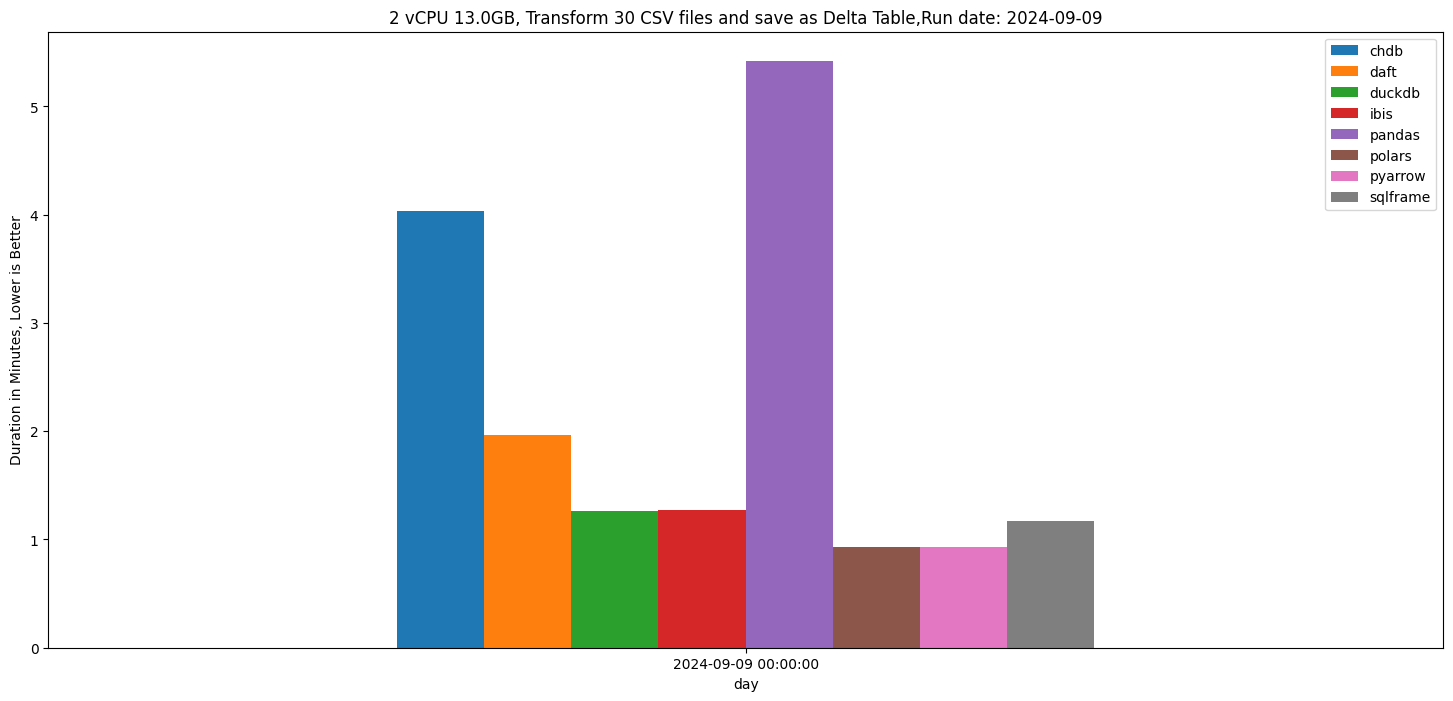

In [57]:
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ f', Transform {total_files} CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
result = duckdb.sql(f"""
            with raw as (select Engine, date_trunc('day',cast(time as TIMESTAMP )) as day,step, avg(duration) as duration
                        from delta_scan('/lakehouse/default/Tables/dbo/results') where total_files = {total_files}
                        group by all),

             result as (select Engine,day, sum(duration)/60 as duration from raw group by all order by duration)

             pivot result on Engine using avg(duration) order by day
                    """).df()
ax = result.plot.bar(rot=0,x='day',title=runtime,ylabel='Duration in Minutes, Lower is Better',figsize=(18,8))